# Book Babies
## DataPrep and Exploratory Data Analysis
EEK, 2024-10-20

## Setup

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np 
import tensorflow_recommenders as tfrs
import tensorflow as tf
import csv
from tqdm import tqdm

from typing import Dict, Text
import re
import json

2024-10-21 16:14:11.176235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Import the CMU Book Summary dataset 
https://www.kaggle.com/datasets/ymaricar/cmu-book-summary-dataset
(Data is released under a Creative Commons Attribution-ShareAlike License)

In [2]:
data = []

with open("data/booksummaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        data.append(row)

book_index = []
book_id = []
book_author = []
book_name = []
summary = []
genre = []
a = 1
for i in tqdm(data):
    book_index.append(a)
    a = a+1
    book_id.append(i[0])
    book_name.append(i[2])
    book_author.append(i[3])
    genre.append(i[5])
    summary.append(i[6])

df_booksum = pd.DataFrame({'Index': book_index, 'ID': book_id, 'BookTitle': book_name, 'Author': book_author,
                       'Genre': genre, 'Summary': summary}).copy()

16559it [00:00, 41606.70it/s]
100%|████████████████████████████████| 16559/16559 [00:00<00:00, 1612384.91it/s]


In [3]:
df_booksum.head()

,Index,ID,BookTitle,Author,Genre,Summary
0,1,620,Animal Farm,George Orwell,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,2,843,A Clockwork Orange,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,3,986,The Plague,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,4,1756,An Enquiry Concerning Human Understanding,David Hume,,The argument of the Enquiry proceeds by a ser...
4,5,2080,A Fire Upon the Deep,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [4]:
df_booksum['Genre'][0]
# useful but messy... 

'{"/m/016lj8": "Roman \\u00e0 clef", "/m/06nbt": "Satire", "/m/0dwly": "Children\'s literature", "/m/014dfn": "Speculative fiction", "/m/02xlf": "Fiction"}'

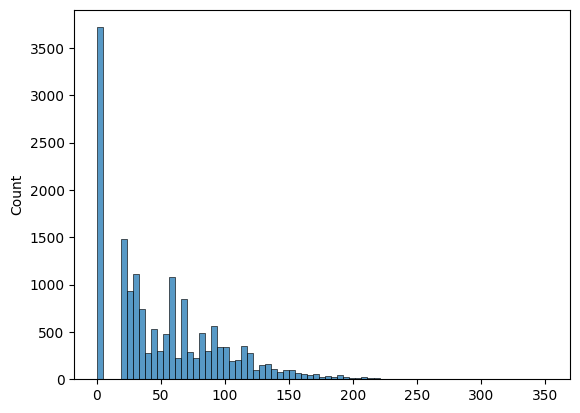

In [5]:
genre_lengths = [len(A) for A in df_booksum.Genre]
pd.Series(genre_lengths).value_counts()[0:5]
sns.histplot(genre_lengths)
plt.show()

#### Clean up the Genre column

In [6]:

df_booksum['genre_list'] = [list(json.loads(re.search('({.+})', A).group(0)).values()) if len(A) > 0 else [] for A in df_booksum.Genre]


#### Inspect the Summary column

In [7]:
df_booksum['Summary'][0][0:300]
# long and rambling

" Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philo"

In [8]:
df_booksum.columns

Index(['Index', 'ID', 'BookTitle', 'Author', 'Genre', 'Summary', 'genre_list'], dtype='object')

In [9]:
# log how long the summary is
df_booksum['Summary_length'] = df_booksum['Summary'].apply(lambda x: len(x))

In [10]:
df_booksum.describe(include = 'all')

,Index,ID,BookTitle,Author,Genre,Summary,genre_list,Summary_length
count,16559.000000,16559,16559,16559,16559,16559,16559,16559.000000
unique,NaN,16559,16277,4715,2155,16532,2155,NaN
top,NaN,620,Nemesis,,,~Plot outline description~ --> <!--,[],NaN
freq,NaN,1,6,2382,3718,13,3718,NaN
mean,8280.000000,NaN,NaN,NaN,NaN,NaN,NaN,2511.108944
std,4780.315889,NaN,NaN,NaN,NaN,NaN,NaN,2903.074330
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000
25%,4140.500000,NaN,NaN,NaN,NaN,NaN,NaN,710.000000
50%,8280.000000,NaN,NaN,NaN,NaN,NaN,NaN,1550.000000
75%,12419.500000,NaN,NaN,NaN,NaN,NaN,NaN,3325.000000


### How Prolific is the author?

In [11]:
df_author = df_booksum[['Author', 'BookTitle']].groupby(['Author']).nunique().reset_index()
df_author.columns = ['Author', 'num_works']
df_author.sort_values(by='num_works', ascending=False).head(10)

,Author,num_works
0,,2379
44,Agatha Christie,74
1421,Franklin W. Dixon,68
2489,K. A. Applegate,62
4147,Stephen King,60
1148,Edgar Rice Burroughs,59
2243,John Dickson Carr,55
3911,Ruth Rendell,55
3390,P. G. Wodehouse,50
1716,Harry Turtledove,49


In [12]:
### What are the entries with no Author noted?

df_booksum[df_booksum.Author==''].sample(10)


,Index,ID,BookTitle,Author,Genre,Summary,genre_list,Summary_length
4057,4058,2839568,Obelix and Co.,,,After Obelix single-handedly defeats the newl...,[],6178
15616,15617,29462305,Perfect: A Novel,,"{""/m/02xlf"": ""Fiction""}",Isabelle Lee is a 13 year old girl whose worl...,[Fiction],2827
16152,16153,31956123,The Fold,,"{""/m/03mfnf"": ""Young adult literature""}",Joyce Park is a Korean adult who just finishe...,[Young adult literature],845
13019,13020,19774558,Bay of the Dead,,,The city of Cardiff is sealed off by unknown ...,[],238
14717,14718,25189629,Shark Girl,,,"Jane Arrowood, an aspiring high school artist...",[],1451
15375,15376,28043467,Eyes of the Shadow,,,"* Plot: One by one, six men who are about to ...",[],370
785,786,297369,The Amethyst Ring,,,"Julián Estaban, who is impersonating the Maya...",[],1418
12824,12825,19188776,Wycliffe and How to Kill a Cat,,,"A young, auburn haired and naked woman turns ...",[],491
12915,12916,19413975,The Fabled Fourth Graders of Aesop Elementary ...,,,The book is about the naughty fourth grade cl...,[],226
12310,12311,17633022,The Thing About Jane Spring,,"{""/m/06cvj"": ""Romantic comedy"", ""/m/01qxvh"": ""...",The plot of the novel revolves around the tit...,"[Romantic comedy, Romance novel]",986


^^ incomplete data or various authors

In [13]:
print(f'''
      Removing the blank authors from the dataset impact {len(df_booksum[df_booksum.Author==''])} rows, 
      which is {len(df_booksum[df_booksum.Author==''])/len(df_booksum)*100:.1f} % of the dataset
      ''')



      Removing the blank authors from the dataset impact 2382 rows, 
      which is 14.4 % of the dataset
      


- 14.4% is a pretty significant number of rows and I'm hesitant to jettison that much of the dataset.
- BUT once a pipeline is working, return to this for incremental improvement # TODO

### Import the Book Recommendation Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?resource=download
(CC0: Public Domain)

In [14]:
df_books = pd.read_csv('data/book_recommendation_dataset/Books.csv')
df_books.head()

/var/folders/mm/b4w49mw16vg2sd4sgpjv83ww0000gn/T/ipykernel_34848/845199900.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('data/book_recommendation_dataset/Books.csv')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [15]:
# To simplify downstream processes, drop the Publisher and take the minimum year of publication
print(f'raw df_books size: {len(df_books)}')
df_books['year_published'] = pd.to_numeric(df_books['Year-Of-Publication'], errors='coerce')

df_books = df_books[~df_books['year_published'].isin(['NaN', 0])].dropna()
print(f'df_books len after dropping 0 and NA: {len(df_books)}')


raw df_books size: 271360
df_books len after dropping 0 and NA: 266735


In [16]:
set(['int' if (type(a) == int or type(a) == float) else a for a in df_books['year_published']])

{'int'}

<Axes: xlabel='year_published', ylabel='Count'>

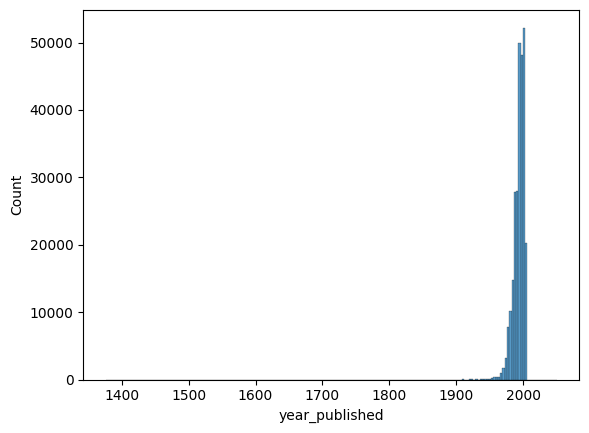

In [17]:
sns.histplot(df_books.year_published, bins=200)

In [18]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,year_published
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2002.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,2001.0
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,1991.0
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,1999.0
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,1999.0


* Book covers - swanky! Not dealing generating a cover embedding at this point.  Maybe on a future iteration... supposedly you can't judge a book by its cover after all :shrug:
  

In [19]:
df_ratings = pd.read_csv('data/book_recommendation_dataset/Ratings.csv').dropna()
df_ratings = df_ratings[df_ratings['Book-Rating']>0]
df_ratings.describe(include='all')

,User-ID,ISBN,Book-Rating
count,433671.000000,433671,433671.000000
unique,NaN,185973,NaN
top,NaN,0316666343,NaN
freq,NaN,707,NaN
mean,135458.743451,NaN,7.601066
std,80678.385078,NaN,1.843798
min,8.000000,NaN,1.000000
25%,66619.000000,NaN,7.000000
50%,133184.000000,NaN,8.000000
75%,205735.000000,NaN,9.000000


We don't need user level data, but it would be helpful to get book-level insight into 
* the popularity (how many people have rated the book?),
* the distribution of popularity (is it a love/hate thing?), and
* the mean rating over all users who have rated it.

We'll join this back in to the book dataset joining on ISBN

In [20]:
df_ratings_agg = df_ratings.groupby(['ISBN']).agg({'User-ID':'nunique', 'Book-Rating':['mean', 'std']})

In [21]:
df_ratings_agg.columns = df_ratings_agg.columns.get_level_values(1)

In [22]:
df_ratings_agg.rename(columns={'nunique': 'num_ratings', 'mean': 'avg_rating', 'std': 'std_rating'}, inplace=True)
df_ratings_agg.sort_values(by=['num_ratings'], ascending=False).reset_index().head()

,ISBN,num_ratings,avg_rating,std_rating
0,0316666343,707,8.185290,1.529098
1,0971880107,581,4.390706,2.379622
2,0385504209,487,8.435318,1.668957
3,0312195516,383,8.182768,1.694777
4,0679781587,333,8.408408,1.548859


In [23]:
df_books = df_books.merge(df_ratings_agg, how='left', left_on='ISBN', right_on='ISBN')
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,year_published,num_ratings,avg_rating,std_rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2002.0,NaN,NaN,NaN
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,2001.0,9.0,7.666667,1.414214
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,1991.0,2.0,7.500000,0.707107
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,1999.0,6.0,7.833333,1.602082
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,1999.0,NaN,NaN,NaN


In [24]:
df_books = df_books[['Book-Title', 'Book-Author', 'year_published', 'num_ratings', 'std_rating', 'avg_rating']].groupby(['Book-Title', 'Book-Author']).agg({'year_published':'min', 'avg_rating': 'mean', 'std_rating': 'mean', 'num_ratings': 'sum'}).reset_index()
print(f'df_books len after aggregating to the nonzero year first released: {len(df_books)}')
df_books = df_books[df_books.num_ratings > 0]
print(f'df_books len after dropping books with no ratings: {len(df_books)}')

df_books len after aggregating to the nonzero year first released: 247209
df_books len after dropping books with no ratings: 137272


In [25]:
df_books.sort_values(by=['num_ratings'], ascending=False).head()

,Book-Title,Book-Author,year_published,avg_rating,std_rating,num_ratings
201235,The Lovely Bones: A Novel,Alice Sebold,2002.0,8.185290,1.529098,707.0
240962,Wild Animus,Rich Shapero,2004.0,4.390706,2.379622,581.0
187950,The Da Vinci Code,Dan Brown,2003.0,9.217659,1.668957,488.0
211793,The Secret Life of Bees,Sue Monk Kidd,2002.0,9.244816,1.297133,406.0
204228,The Nanny Diaries: A Novel,Emma McLaughlin,2002.0,7.418830,1.728374,393.0


In [26]:

weighted_mean = lambda x: np.average(x, weights=df_books.loc[x.index, "num_ratings"])
df_authors = df_books[['Book-Author', 'avg_rating', 'num_ratings']].groupby(['Book-Author']).agg({'avg_rating':weighted_mean, 'num_ratings':'sum'}).reset_index()
df_authors.columns = ['Author', 'avg_rating_author', 'num_ratings_author']
df_authors.sort_values(by=['num_ratings_author'], ascending=False).head(10)


,Author,avg_rating_author,num_ratings_author
54682,Stephen King,7.630382,4602.0
43933,Nora Roberts,7.614782,2938.0
29117,John Grisham,7.452818,2527.0
25516,James Patterson,7.782976,2386.0
24077,J. K. Rowling,8.924903,1746.0
39738,Mary Higgins Clark,7.378698,1672.0
26127,Janet Evanovich,7.951425,1489.0
12962,Dean R. Koontz,7.745056,1475.0
3160,Anne Rice,7.210160,1245.0
55301,Sue Grafton,7.641180,1234.0


<Axes: xlabel='avg_rating', ylabel='Count'>

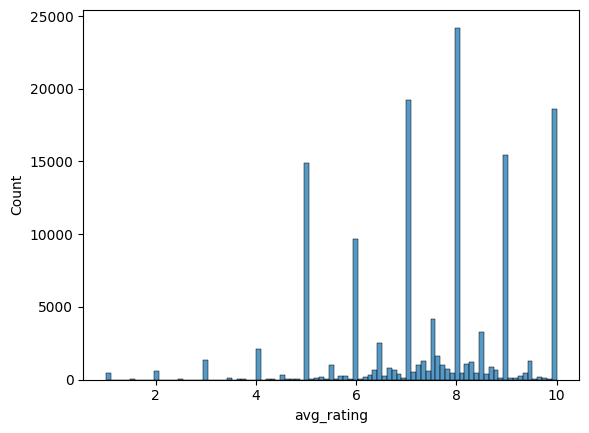

In [27]:
sns.histplot(df_books.avg_rating)

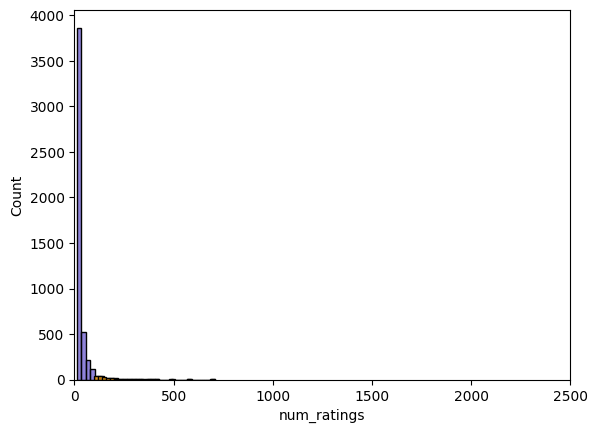

In [28]:
sns.histplot(df_books.num_ratings[df_books.num_ratings > 10], bins=30, color='slateblue')
sns.histplot(df_books.num_ratings[df_books.num_ratings > 100], bins=30, color='orange')
plt.xlim(0, 2500)
plt.show()

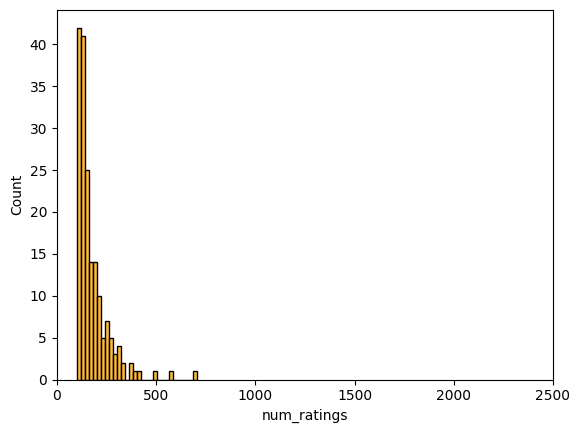

In [29]:
sns.histplot(df_books.num_ratings[df_books.num_ratings > 100], bins=30, color='orange')
plt.xlim(0, 2500)
plt.show()

<Axes: xlabel='avg_rating', ylabel='Count'>

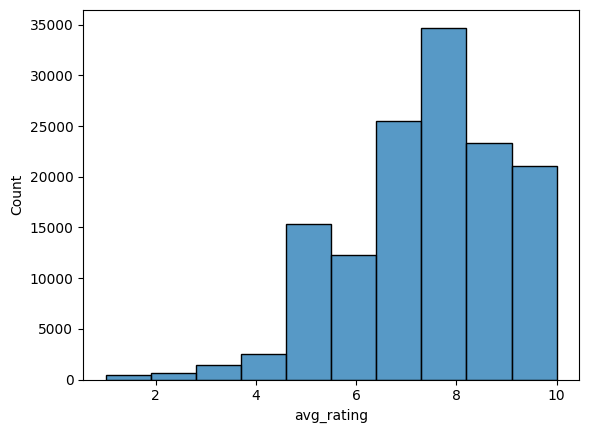

In [30]:
sns.histplot(data=df_books[df_books.avg_rating>0], x='avg_rating', bins=10)

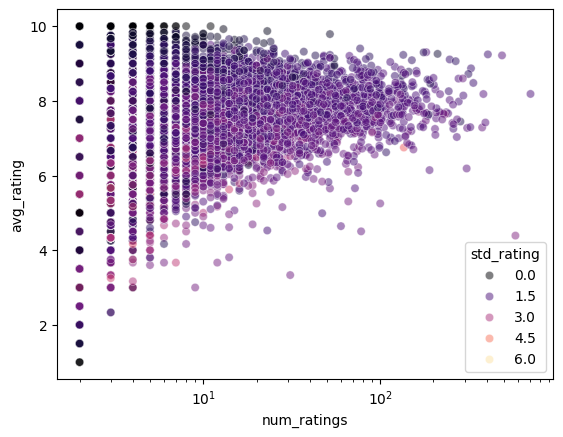

In [31]:
sns.scatterplot(data=df_books, x='num_ratings', y='avg_rating', hue='std_rating', palette='magma', alpha=0.5)
plt.xscale('log')
plt.show()

In [32]:
# nothing very useful in the users dataset at this point since we're not generating user-level personalized recommendations
# df_users = pd.read_csv('data/book_recommendation_dataset/Users.csv')
# df_users.describe(include='all')

### Import the Book Depository Dataset
https://www.kaggle.com/datasets/sp1thas/book-depository-dataset?select=dataset.csv
Noncommercial CC ShareAlike License

In [33]:
df_bookdepot = pd.read_csv('data/book_depository_dataset/dataset.csv')
df_bookdepot.head()

,authors,bestsellers-rank,categories,description,dimension-x,dimension-y,dimension-z,edition,edition-statement,for-ages,...,isbn10,isbn13,lang,publication-date,publication-place,rating-avg,rating-count,title,url,weight
0,[1],49848.0,"[214, 220, 237, 2646, 2647, 2659, 2660, 2679]",SOLDIER FIVE is an elite soldier's explosive m...,129.0,198.0,20.0,NaN,NaN,NaN,...,184018907X,9781840189070,en,2004-10-14 00:00:00,NaN,4.03,292.0,Soldier Five : The Real Truth About The Bravo ...,/Soldier-Five-Mike-Coburn/9781840189070,224.00
1,"[2, 3]",115215.0,"[235, 3386]",John Moran and Carl Williams were the two bigg...,127.0,203.2,25.4,NaN,NaN,NaN,...,184454737X,9781844547371,en,2009-03-13 00:00:00,NaN,3.60,335.0,Underbelly : The Gangland War,/Underbelly-Andrew-Rule/9781844547371,285.76
2,[4],11732.0,"[358, 2630, 360, 2632]",Sir Phillip knew that Eloise Bridgerton was a ...,150.0,224.0,28.0,New edition,NaN,NaN,...,8416327866,9788416327867,es,2020-04-30 00:00:00,NaN,3.88,37211.0,"A Sir Phillip, Con Amor",/Sir-Phillip-Con-Amor-Julia-Quinn/9788416327867,386.00
3,"[5, 6, 7, 8]",114379.0,"[377, 2978, 2980]",The Third Book of General Ignorance gathers t...,153.0,234.0,24.0,NaN,Export - Airside ed,NaN,...,571308996,9780571308996,en,2015-10-01 00:00:00,NaN,4.17,384.0,QI: The Third Book of General Ignorance,/QI-Third-Book-General-Ignorance-John-Lloyd/97...,436.00
4,[9],98413.0,"[2813, 2980]",The Try Guys deliver their first book-an inspi...,191.0,240.0,29.0,NaN,NaN,NaN,...,8352518,9780008352516,en,2019-06-18 00:00:00,NaN,3.90,5095.0,The Hidden Power of F*cking Up,/Hidden-Power-F-cking-Up-Try-Guys/9780008352516,980.00


In [34]:
df_bookdepot.describe(include='all')

,authors,bestsellers-rank,categories,description,dimension-x,dimension-y,dimension-z,edition,edition-statement,for-ages,...,isbn10,isbn13,lang,publication-date,publication-place,rating-avg,rating-count,title,url,weight
count,1109383,6.425410e+05,1109383,1029296,1.061156e+06,1.015852e+06,1.061156e+06,182814,360346,75993,...,1109383,1.109383e+06,1048976,1106780,0.0,669253.000000,6.692530e+05,1109383,1109383,1.022210e+06
unique,564646,NaN,425186,841392,NaN,NaN,NaN,104,11292,55,...,1109382,NaN,162,14976,NaN,NaN,NaN,957559,1109383,NaN
top,[],NaN,[2964],This book is a facsimile reprint and may conta...,NaN,NaN,NaN,Unabridged,Unabridged,12-17,...,1572507063,NaN,en,2010-09-10 00:00:00,NaN,NaN,NaN,Journal Your Life's Journey : Journals To Writ...,/Soldier-Five-Mike-Coburn/9781840189070,NaN
freq,17495,NaN,4944,16770,NaN,NaN,NaN,82505,55697,39267,...,2,NaN,986575,12335,NaN,NaN,NaN,208,1,NaN
mean,NaN,9.209777e+05,NaN,NaN,1.607659e+02,2.249102e+02,2.644117e+01,NaN,NaN,NaN,...,NaN,9.781658e+12,NaN,NaN,NaN,3.974918,1.239215e+04,NaN,NaN,4.616623e+02
std,NaN,8.642210e+05,NaN,NaN,3.802671e+01,4.347322e+01,4.779869e+01,NaN,NaN,NaN,...,NaN,1.747523e+09,NaN,NaN,NaN,0.543605,1.333263e+05,NaN,NaN,6.587618e+02
min,NaN,1.001000e+03,NaN,NaN,2.500000e-01,1.000000e+00,1.000000e-01,NaN,NaN,NaN,...,NaN,9.780000e+12,NaN,NaN,NaN,1.000000,1.000000e+00,NaN,NaN,1.500000e+01
25%,NaN,1.654890e+05,NaN,NaN,1.380000e+02,2.030000e+02,9.000000e+00,NaN,NaN,NaN,...,NaN,9.780801e+12,NaN,NaN,NaN,3.730000,5.000000e+00,NaN,NaN,1.814400e+02
50%,NaN,6.646830e+05,NaN,NaN,1.520000e+02,2.290000e+02,1.575000e+01,NaN,NaN,NaN,...,NaN,9.781474e+12,NaN,NaN,NaN,4.000000,3.900000e+01,NaN,NaN,3.180000e+02
75%,NaN,1.455812e+06,NaN,NaN,1.780000e+02,2.420000e+02,2.500000e+01,NaN,NaN,NaN,...,NaN,9.781743e+12,NaN,NaN,NaN,4.260000,5.200000e+02,NaN,NaN,5.352400e+02


## How much overlap is there between the recommendation set and the CMU dataset?

In [35]:
df_combo1 = df_booksum.merge(df_books, how='left', left_on=['BookTitle', 'Author'], right_on=['Book-Title', 'Book-Author'])

In [36]:
df_combo1.describe(include='all')

,Index,ID,BookTitle,Author,Genre,Summary,genre_list,Summary_length,Book-Title,Book-Author,year_published,avg_rating,std_rating,num_ratings
count,16559.000000,16559,16559,16559,16559,16559,16559,16559.000000,3196,3196,3196.000000,3196.000000,2183.000000,3196.000000
unique,NaN,16559,16277,4715,2155,16532,2155,NaN,3181,1340,NaN,NaN,NaN,NaN
top,NaN,620,Nemesis,,,~Plot outline description~ --> <!--,[],NaN,Peter Pan,Agatha Christie,NaN,NaN,NaN,NaN
freq,NaN,1,6,2382,3718,13,3718,NaN,2,47,NaN,NaN,NaN,NaN
mean,8280.000000,NaN,NaN,NaN,NaN,NaN,NaN,2511.108944,NaN,NaN,1990.550688,7.716118,1.488259,13.099812
std,4780.315889,NaN,NaN,NaN,NaN,NaN,NaN,2903.074330,NaN,NaN,10.779607,1.235548,0.728360,30.506928
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,NaN,NaN,1910.000000,1.000000,0.000000,1.000000
25%,4140.500000,NaN,NaN,NaN,NaN,NaN,NaN,710.000000,NaN,NaN,1984.000000,7.000000,1.023557,1.000000
50%,8280.000000,NaN,NaN,NaN,NaN,NaN,NaN,1550.000000,NaN,NaN,1993.000000,7.887112,1.460258,3.000000
75%,12419.500000,NaN,NaN,NaN,NaN,NaN,NaN,3325.000000,NaN,NaN,1999.000000,8.500000,1.861853,10.000000


In [37]:
df_combo2 = df_booksum.merge(df_books, how='inner', left_on=['BookTitle', 'Author'], right_on=['Book-Title', 'Book-Author']).drop(['Book-Title', 'Book-Author', 'Genre', 'ID', 'Index'], axis=1)

In [38]:
df_combo2.describe(include='all')

,BookTitle,Author,Summary,genre_list,Summary_length,year_published,avg_rating,std_rating,num_ratings
count,3196,3196,3196,3196,3196.000000,3196.000000,3196.000000,2183.000000,3196.000000
unique,3181,1340,3196,863,NaN,NaN,NaN,NaN,NaN
top,Peter Pan,Agatha Christie,"Old Major, the old boar on the Manor Farm, ca...",[],NaN,NaN,NaN,NaN,NaN
freq,2,47,1,244,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2972.673655,1990.550688,7.716118,1.488259,13.099812
std,NaN,NaN,NaN,NaN,2920.251256,10.779607,1.235548,0.728360,30.506928
min,NaN,NaN,NaN,NaN,35.000000,1910.000000,1.000000,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,976.750000,1984.000000,7.000000,1.023557,1.000000
50%,NaN,NaN,NaN,NaN,2109.000000,1993.000000,7.887112,1.460258,3.000000
75%,NaN,NaN,NaN,NaN,4047.000000,1999.000000,8.500000,1.861853,10.000000


* CMU has 16.5k books - the inner join with the 247k books in the df_books dataset leaves us with only 3200.
* I'll move forward for now but would like to consider if there are other sources with a more complete dataset.

In [39]:
df_combo2.head()

,BookTitle,Author,Summary,genre_list,Summary_length,year_published,avg_rating,std_rating,num_ratings
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ...",5812,1956.0,8.281910,1.721726,120.0
1,The Plague,Albert Camus,The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N...",6642,1972.0,8.111111,1.166667,9.0
2,All Quiet on the Western Front,Erich Maria Remarque,"The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]",4283,1990.0,8.531250,1.413857,32.0
3,Crash,J. G. Ballard,The story is told through the eyes of narrato...,"[Speculative fiction, Fiction, Novel]",659,1996.0,6.000000,NaN,1.0
4,Children of Dune,Frank Herbert,Nine years after Emperor Paul Muad'dib walked...,"[Science Fiction, Speculative fiction, Childre...",3826,1977.0,8.875000,2.121320,5.0


In [40]:
# Join in the author data 

df = df_combo2.merge(df_authors, how='left', left_on='Author', right_on='Author')
df = df.merge(df_author, how='left', left_on='Author', right_on='Author')
df.head()

,BookTitle,Author,Summary,genre_list,Summary_length,year_published,avg_rating,std_rating,num_ratings,avg_rating_author,num_ratings_author,num_works
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ...",5812,1956.0,8.281910,1.721726,120.0,8.565043,344.0,8
1,The Plague,Albert Camus,The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N...",6642,1972.0,8.111111,1.166667,9.0,8.039720,107.0,7
2,All Quiet on the Western Front,Erich Maria Remarque,"The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]",4283,1990.0,8.531250,1.413857,32.0,8.391304,46.0,4
3,Crash,J. G. Ballard,The story is told through the eyes of narrato...,"[Speculative fiction, Fiction, Novel]",659,1996.0,6.000000,NaN,1.0,7.431818,11.0,17
4,Children of Dune,Frank Herbert,Nine years after Emperor Paul Muad'dib walked...,"[Science Fiction, Speculative fiction, Childre...",3826,1977.0,8.875000,2.121320,5.0,8.208907,353.0,20


The publication dates are not reliable - just spot checking, A Clockwork Orange isn't correct - it was published in 1962 not 1994.

Does the bookdepot dataset do any better?

In [41]:
min(df_bookdepot[df_bookdepot.title=='A Clockwork Orange']['publication-date'])

'2008-09-01 00:00:00'

In [42]:
# df_bookdepot[df_bookdepot.title=='A Clockwork Orange']

<span style='color:blue;font-weight:900'>Nope!</span>

## Genre Counts

In [43]:
genre_dict = {}
for a in df.genre_list:
    for i in a:
        if i in genre_dict.keys():
            genre_dict[i] += 1
        else:
            genre_dict[i] = 1

In [44]:
df_genre_summary = pd.DataFrame.from_dict(genre_dict, orient='index').reset_index()
df_genre_summary.columns = ['genre', 'count_in_genre']
df_genre_summary.sort_values(by='count_in_genre', ascending=False).head(10)

,genre,count_in_genre
4,Fiction,1761
3,Speculative fiction,1225
7,Novel,772
9,Science Fiction,646
2,Children's literature,603
14,Fantasy,533
12,Mystery,391
23,Suspense,311
57,Crime Fiction,237
40,Thriller,181


<Axes: xlabel='count_in_genre', ylabel='genre'>

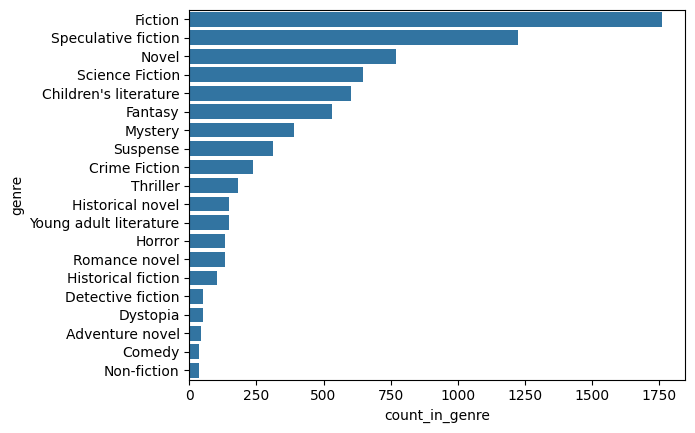

In [45]:
sns.barplot(data=df_genre_summary.sort_values(by='count_in_genre', ascending=False).head(20), y='genre', x='count_in_genre')

In [46]:
print(f'There are {len(df_genre_summary)} different genres represented in this dataset')

There are 155 different genres represented in this dataset


In [53]:
df_genre_summary = df_genre_summary.sort_values(by='count_in_genre', ascending=False).reset_index(drop=True)
df_genre_summary.head()

,index,genre,count_in_genre
0,4,Fiction,1761
1,3,Speculative fiction,1225
2,7,Novel,772
3,9,Science Fiction,646
4,2,Children's literature,603


In [47]:
df_genre_summary.describe()

,count_in_genre
count,155.000000
mean,54.174194
std,201.592399
min,1.000000
25%,1.500000
50%,4.000000
75%,13.000000
max,1761.000000


In [48]:
df.head()

,BookTitle,Author,Summary,genre_list,Summary_length,year_published,avg_rating,std_rating,num_ratings,avg_rating_author,num_ratings_author,num_works
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ...",5812,1956.0,8.281910,1.721726,120.0,8.565043,344.0,8
1,The Plague,Albert Camus,The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N...",6642,1972.0,8.111111,1.166667,9.0,8.039720,107.0,7
2,All Quiet on the Western Front,Erich Maria Remarque,"The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]",4283,1990.0,8.531250,1.413857,32.0,8.391304,46.0,4
3,Crash,J. G. Ballard,The story is told through the eyes of narrato...,"[Speculative fiction, Fiction, Novel]",659,1996.0,6.000000,NaN,1.0,7.431818,11.0,17
4,Children of Dune,Frank Herbert,Nine years after Emperor Paul Muad'dib walked...,"[Science Fiction, Speculative fiction, Childre...",3826,1977.0,8.875000,2.121320,5.0,8.208907,353.0,20


<Axes: xlabel='std_rating', ylabel='Count'>

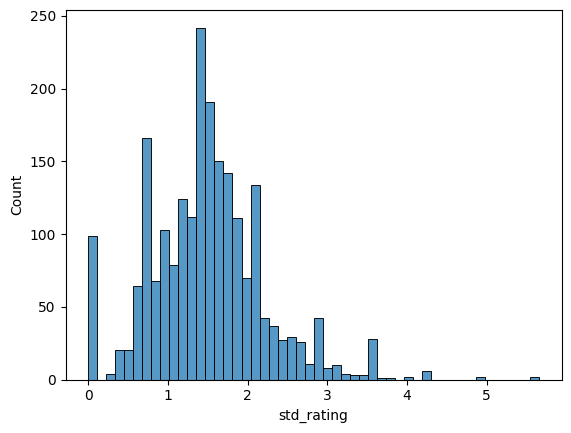

In [49]:
sns.histplot(data=df, x='std_rating', bins=50)

In [50]:
df.to_csv('data/data_cleaned.csv')